In [96]:
# importing all the necessary packages I'll be using
import numpy as np
import gym
from gym import spaces
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import random
import matplotlib.pyplot as plt
import random

# Defining the Environment



In [97]:
class MedicationReminderEnv(gym.Env):
    """
    This class implements a Gym environment for simulating a medication reminder system.
    The environment includes an agent that decides whether to send a medication reminder at specific hours.
    """

    metadata = {'render.modes': ['console']}

    def __init__(self):
        """
        Initializes the MedicationReminderEnv environment.
        
        Attributes:
            action_space: A gym space representing possible actions (0: send reminder, 1: do not send reminder).
            observation_space: A gym space representing possible states.
            medication_hours: A list of hours at which medication should be taken.
            state: An array representing the current state (hour, medication taken, reminder sent).
        """
        super(MedicationReminderEnv, self).__init__()
        self.action_space = spaces.Discrete(2)  # 0: send reminder, 1: do not send reminder
        self.observation_space = spaces.MultiDiscrete([24, 2, 2])  # hour, medication taken, reminder sent
        self.medication_hours = [8, 20]  # Medication should be taken at 8 AM and 8 PM
        self.state = np.array([12, 0, 0])  # Initial state: midday, no medication taken, no reminder sent

    def step(self, action):
        """
        Executes one step within the environment.
        
        Args:
            action: An integer representing the action taken by the agent.
        
        Returns:
            state: The new state after taking the action.
            reward: The reward obtained from the action.
            done: A boolean indicating whether the episode is finished.
            info: Additional information about the step.
        """
        hour, taken, _ = self.state
        hour = (hour + 1) % 24
        reward = -0.1  # Base penalty for time passing

        if hour in self.medication_hours:
            if action == 0:  # Reminder sent
                if taken == 0:
                    reward += 10.0  # Large reward for the best reminder leading to medication
                else:
                    reward += 2  # Smaller reward if reminder is sent but medication was already taken
            else:
                reward -= 1  # Penalty for not sending reminder when needed
        else:
            if action == 0:  # Reminder sent when not needed
                reward -= 0.2  # Smaller penalty for unnecessary reminder

        self.state = np.array([hour, np.random.choice([0, 1], p=[0.2, 0.8] if action == 0 else [0.9, 0.1]), action])
        done = hour == 23  # End of the day
        return self.state, reward, done, {}


    def reset(self):
        """
        Resets the environment to its initial state.
        
        Returns:
            state: The initial state after reset.
        """
        self.state = np.array([np.random.randint(0, 24), 0, 0])  
        return self.state
    

    def render(self, mode='console'):
        """
        Renders the current state of the environment.
        
        Args:
            mode: The rendering mode (default is 'console').
        """
        print(f"Hour: {self.state[0]}, Medication Taken: {'Yes' if self.state[1] == 1 else 'No'}, Reminder Sent: {'Yes' if self.state[2] == 0 else 'No'}")


def evaluate_agent(env, agent, episodes=100):
    """
    Evaluates an agent within the specified environment over multiple episodes.
    
    Args:
        env: The environment in which the agent operates.
        agent: The agent being evaluated.
        episodes: The number of episodes to run.
    
    Returns:
        total_rewards: A list of total rewards obtained in each episode.
        average_reward: The average reward across all episodes.
        cumulative_reward: The total cumulative reward across all episodes.
        sample_efficiency: The average number of steps per episode.
        convergence_rate: The average reward over the last 10 episodes, assumed to represent convergence.
    """
    total_rewards = []
    steps_per_episode = []

    for _ in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        while True:
            action = agent.act(state)  
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state 
            steps += 1
            if done:
                break

        total_rewards.append(total_reward)
        steps_per_episode.append(steps)

    average_reward = np.mean(total_rewards)
    cumulative_reward = np.sum(total_rewards)
    sample_efficiency = np.mean(steps_per_episode)
    convergence_rate = np.mean(total_rewards[-10:])  

    return total_rewards, average_reward, cumulative_reward, sample_efficiency, convergence_rate


# Implementing the Deep Q-Network (DQN) Agent

In [98]:
class DQNAgent:
    """
    This class implements a Deep Q-Network (DQN) agent for our system.
    """

    def __init__(self, state_size, action_size):
        """
        Initializes the DQNAgent.
        
        Args:
            state_size: The size of the state space.
            action_size: The size of the action space.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  
        self.epsilon = 1.0 
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        """
        Builds the neural network model for the DQN agent.
        
        Returns:
            model: The constructed neural network model.
        """
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        return model

    def remember(self, state, action, reward, next_state, done):
        """
        Records a state transition in the agent's memory.
        
        Args:
            state: The current state.
            action: The action taken.
            reward: The reward received.
            next_state: The next state.
            done: A boolean indicating whether the episode is finished.
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Selects an action based on the current state.
        
        Args:
            state: The current state.
        
        Returns:
            action: The selected action.
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """
        Performs experience replay to update the agent's Q-network.
        
        Args:
            batch_size: The size of the minibatch for replay.
        """
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

env = MedicationReminderEnv()
agent = DQNAgent(state_size=3, action_size=2)

# Training the agent
def train_dqn(episodes):
    """
    Trains the DQN agent over a specified number of episodes.
    
    Args:
        episodes: The number of episodes to train.
    """
    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, 3])  
        for time in range(500):  # Limiting each episode to 500 steps
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, 3])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print(f"Episode: {e+1}, Score: {time}, Epsilon: {agent.epsilon}")
                break
            if len(agent.memory) > 32:
                agent.replay(32)

train_dqn(100)  # We decide to train for 100 episodes


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
Episode: 94, Score: 23, Epsilon: 0.00998645168764533
1/1 [==============================] - 0s 30ms/step
Episode: 95, Score: 16, Epsilon: 0.00998645168764533
1/1 [==============================] - 0s 30ms/step
Episode: 96, Score: 22, Epsilon: 0.00998645168764533
1/1 [==============================] - 0s 35ms/step
Episode: 97, Score: 17, Epsilon: 0.00998645168764533
1/1 [==============================] - 0s 47ms/step
Episode: 98, Score: 3, Epsilon: 0.00998645168764533
1/1 [==============================] - 0s 25ms/step
Episode: 99, Score: 3, Epsilon: 0.00998645168764533
1/1 [==============================] - 0s 33ms/step
Episode: 100, Score: 16, Epsilon: 0.00998645168764533


# Implementing a Basic Q-Learning Agent

In [100]:
class QLearningAgent:
    """
    This class implements a Q-learning agent for our system.
    """

    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0,
                 exploration_decay=0.995, exploration_min=0.01):
        """
        Initializes the QLearningAgent.
        Args:
            state_size: The size of the state space.
            action_size: The size of the action space.
            learning_rate: The learning rate for updating Q-values (default is 0.1).
            discount_factor: The discount factor for future rewards (default is 0.99).
            exploration_rate: The initial exploration rate (default is 1.0).
            exploration_decay: The decay rate for exploration rate (default is 0.995).
            exploration_min: The minimum exploration rate (default is 0.01).
        """
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.epsilon_min = exploration_min
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        """
        Chooses an action based on the current state using an epsilon-greedy policy.
        Args:
            state: The current state.
        Returns:
            action: The selected action.
        """
        state_index = self.state_to_index(state)
        if random.uniform(0, 1) < self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.q_table[state_index])

    def learn(self, state, action, reward, next_state, done):
        """
        Updates the Q-value based on the observed transition.
        Args:
            state: The current state.
            action: The action taken.
            reward: The reward received.
            next_state: The next state.
            done: A boolean indicating whether the episode is finished.
        """
        state_index = self.state_to_index(state)
        next_state_index = self.state_to_index(next_state)
        target = reward + (self.gamma * np.max(self.q_table[next_state_index]) if not done else 0)
        self.q_table[state_index, action] += self.learning_rate * (target - self.q_table[state_index, action])
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def act(self, state):  
        """
        Acts according to the current policy.
        Args:
            state: The current state.
        Returns:
            action: The selected action.
        """
        return self.choose_action(state)

    def state_to_index(self, state):
        """
        Converts a state array into a single integer index for the Q-table.
        Args:
            state: The current state.
        Returns:
            index: The index representing the state in the Q-table.
        """
        return state[0] * 4 + state[1] * 2 + state[2]


def train_q_learning(env, agent, episodes):
    """
    Trains the Q-learning agent within the specified environment over a number of episodes.

    Args:
        env: The environment in which the agent operates.
        agent: The Q-learning agent.
        episodes: The number of episodes to train.
    """
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        while True:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps += 1
            if done:
                break
        print(f"Episode {e+1}: Total Reward = {total_reward}, Steps = {steps}, Epsilon = {agent.epsilon}")


env = MedicationReminderEnv()
state_size = env.observation_space.nvec.prod()  
action_size = env.action_space.n  
agent = QLearningAgent(state_size=state_size, action_size=action_size)
num_episodes = 5
# Training the Q-Learning agent
train_q_learning(env, agent, num_episodes)


Episode 1: Total Reward = -0.3000000000000003, Steps = 13, Epsilon = 0.995
Episode 2: Total Reward = -0.9000000000000001, Steps = 3, Epsilon = 0.990025
Episode 3: Total Reward = 8.500000000000002, Steps = 11, Epsilon = 0.985074875
Episode 4: Total Reward = 4.400000000000002, Steps = 24, Epsilon = 0.9801495006250001
Episode 5: Total Reward = 9.600000000000001, Steps = 16, Epsilon = 0.9752487531218751


# Model Evaluation

DQN Model Evaluation:
Cumulative Reward: 94.39999999999998, Average Reward: 0.9439999999999997, Sample Efficiency: 12.94, Convergence Rate: 0.6699999999999999

Q-Learning Model Evaluation:
Cumulative Reward: 86.59999999999997, Average Reward: 0.8659999999999997, Sample Efficiency: 13.28, Convergence Rate: 3.6399999999999997


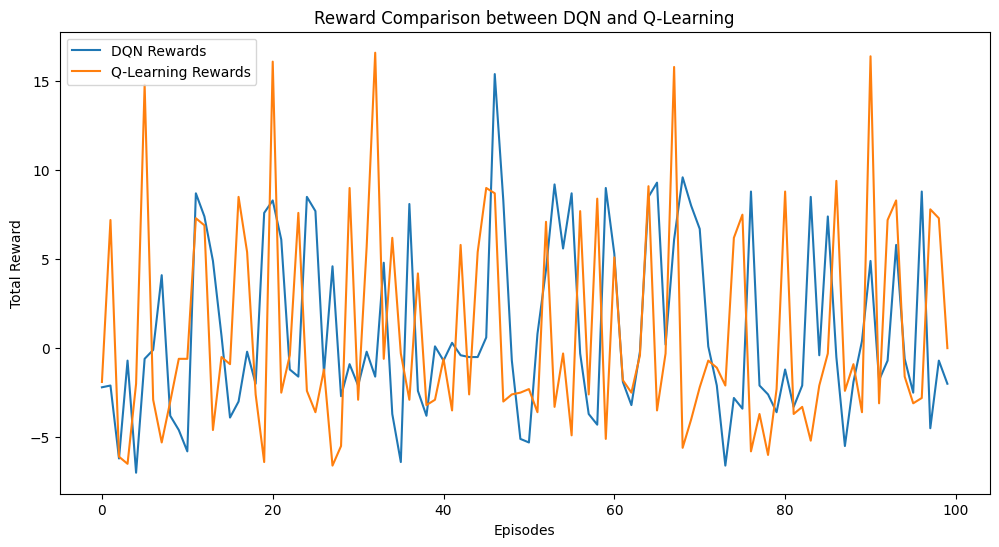

In [101]:
def evaluate_agent(env, agent, episodes=100):
    """
    Evaluates the performance of an agent within the specified environment over multiple episodes.
    Args:
        env: The environment in which the agent operates.
        agent: The agent being evaluated.
        episodes: The number of episodes to run.
    Returns:
        total_rewards: A list of total rewards obtained in each episode.
        average_reward: The average reward across all episodes.
        cumulative_reward: The total cumulative reward across all episodes.
        sample_efficiency: The average number of steps per episode.
        convergence_rate: The average reward over the last 10 episodes, assumed to represent convergence.
    """
    total_rewards = []
    steps_per_episode = []

    for _ in range(episodes):
        state = env.reset()
        if isinstance(agent, DQNAgent):
            state = np.reshape(state, [1, 3])  

        total_reward = 0
        steps = 0

        while True:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            if isinstance(agent, DQNAgent):
                next_state = np.reshape(next_state, [1, 3])  

            total_reward += reward
            state = next_state
            steps += 1
            if done:
                break

        total_rewards.append(total_reward)
        steps_per_episode.append(steps)

    average_reward = np.mean(total_rewards)
    cumulative_reward = np.sum(total_rewards)
    sample_efficiency = np.mean(steps_per_episode)
    convergence_rate = np.mean(total_rewards[-10:])  

    return total_rewards, average_reward, cumulative_reward, sample_efficiency, convergence_rate

# Initializing the environment and agents
env = MedicationReminderEnv()  
state_size = env.observation_space.nvec.prod()  
action_size = env.action_space.n  

# Initializing my DQN Agent
dqn_agent = DQNAgent(state_size=state_size, action_size=action_size)

# Initializing my Q-Learning Agent
q_learning_agent = QLearningAgent(state_size=state_size, action_size=action_size)

# Evaluating both of the agents
dqn_rewards, dqn_avg, dqn_cum, dqn_samples, dqn_convergence = evaluate_agent(env, dqn_agent, episodes=100)
q_learning_rewards, q_avg, q_cum, q_samples, q_convergence = evaluate_agent(env, q_learning_agent, episodes=100)

# reporting my results
print("DQN Model Evaluation:")
print(f"Cumulative Reward: {dqn_cum}, Average Reward: {dqn_avg}, Sample Efficiency: {dqn_samples}, Convergence Rate: {dqn_convergence}")

print("\nQ-Learning Model Evaluation:")
print(f"Cumulative Reward: {q_cum}, Average Reward: {q_avg}, Sample Efficiency: {q_samples}, Convergence Rate: {q_convergence}")

# Plotting 
plt.figure(figsize=(12, 6))
plt.plot(dqn_rewards, label='DQN Rewards')
plt.plot(q_learning_rewards, label='Q-Learning Rewards')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Reward Comparison between DQN and Q-Learning')
plt.legend()
plt.show()


## The Trendline of the above plot

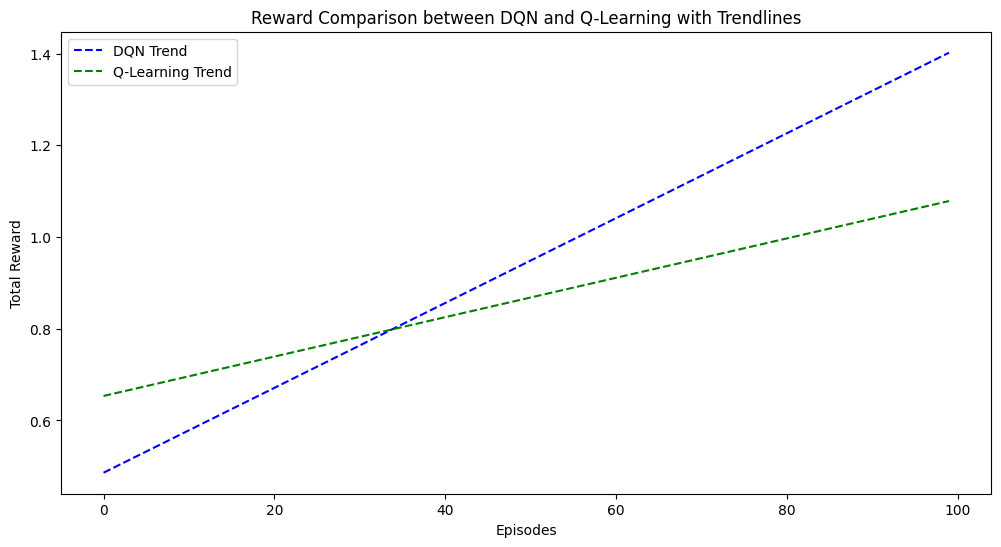

In [102]:

z_dqn = np.polyfit(range(len(dqn_rewards)), dqn_rewards, 1)
p_dqn = np.poly1d(z_dqn)

z_q_learning = np.polyfit(range(len(q_learning_rewards)), q_learning_rewards, 1)
p_q_learning = np.poly1d(z_q_learning)


trend_dqn = p_dqn(range(len(dqn_rewards)))
trend_q_learning = p_q_learning(range(len(q_learning_rewards)))


plt.figure(figsize=(12, 6))
plt.plot(trend_dqn, label='DQN Trend', linestyle="--", color='blue')
plt.plot(trend_q_learning, label='Q-Learning Trend', linestyle="--", color='green')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Reward Comparison between DQN and Q-Learning with Trendlines')
plt.legend()
plt.show()
